Author: Nikolaos Mastrantonas\
Date  : 12-06-2022

The proposed **lasagna plot** serves mainly the purpose of **plotting fast the key information from the ensemble data**, making at the same time the plot **clearer**, when compared to the currently used spaghetti plot.
As can be seen in the below tests, the time of the plotting depends on the projection used.

**Orthographic projection** : Spaghetti -> 152.0 seconds, Lasagna -> 11.6 seconds, **12-times increase in speed**

**PlateCarree projection**  : Spaghetti ->  30.8 seconds, Lasagna ->  7.6 seconds,  **4-times increase in speed**

Thanks to Cihan Sahin for suggesting to work on ways of improving the speed and/or visualization of the currently available products using spaghetti plots.

In [ ]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf

import warnings
warnings.filterwarnings('ignore')

Data downloaded from https://get.ecmwf.int/#browse/browse:vishackathon (Thanks to Milana Vuckovic for providing them)

In [2]:
data_loc = ''

In [3]:
data_raw = xr.open_dataarray(data_loc+'hundred_members_msl_pf.grib', engine='cfgrib')
data_raw = data_raw.reset_coords(drop=True)/100  # convert to hPa

In [4]:
# add the 360 longitude values being equal as the ones at longitude=0. Needed so that plotting is continuous
zero_lon = data_raw.sel(longitude=data_raw.longitude.values[0])
data_raw = xr.concat([data_raw, zero_lon.assign_coords({'longitude': 360})], dim='longitude')
del(zero_lon)

In [5]:
x, y = np.meshgrid(data_raw.longitude, data_raw.latitude) # mesh used for the plotting

In [6]:
used_level = 1015
i_step = 4

### Spaghetti Plots
The commonly used plots, where each ensemble member is plotted.

CPU times: user 1min 31s, sys: 2.07 s, total: 1min 33s
Wall time: 1min 33s


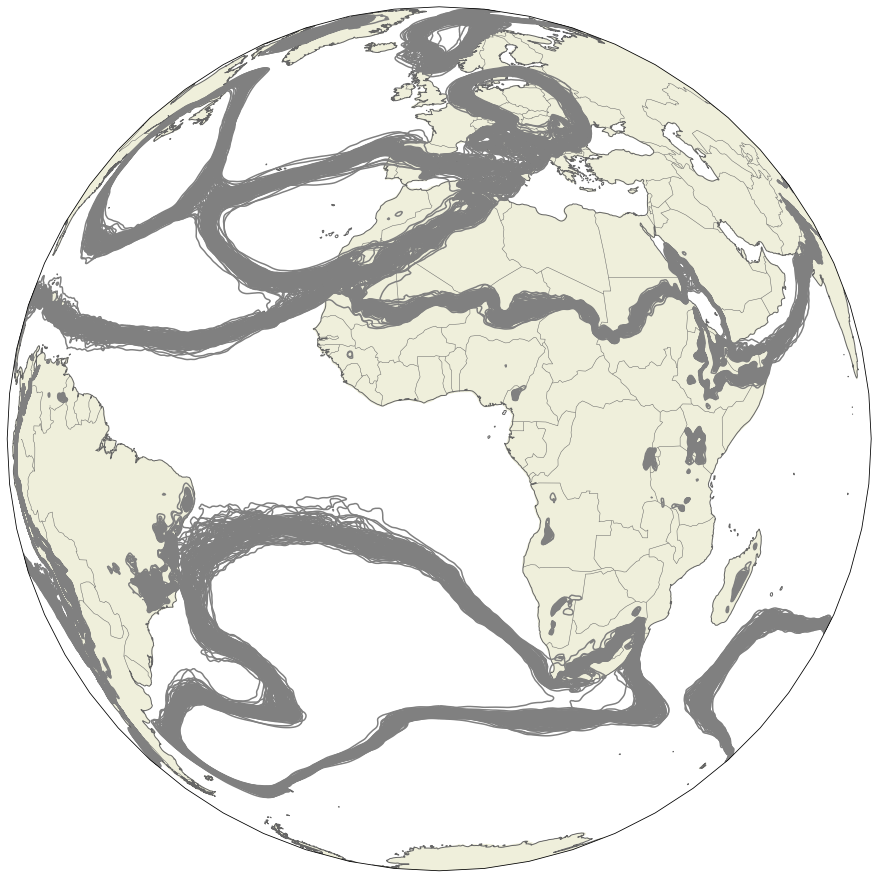

In [7]:
%%time
# ------- select data to be plotted
data_kept = data_raw.isel(step=i_step)

# ------- start figure
fig, ax = plt.subplots(1, 1, figsize=(20, 12), subplot_kw=dict(projection=ccrs.Orthographic()))

for i_num in data_kept.number.values:
    ax.contour(x, y, data_kept.sel(number=i_num),  
               transform=ccrs.PlateCarree(), levels=[used_level], colors=['grey'])

ax.coastlines(resolution='50m', linewidth=1, color='.4') # add coastline
ax.add_feature(cf.BORDERS, linewidth=.5, color='.4')
ax.add_feature(cf.LAND)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0)

fig.savefig(data_loc+f'Orthographic_Spaghetti_{i_step+1}.png', dpi=600)
del(data_kept, fig, ax, i_num)

CPU times: user 28.2 s, sys: 2.49 s, total: 30.7 s
Wall time: 30.8 s


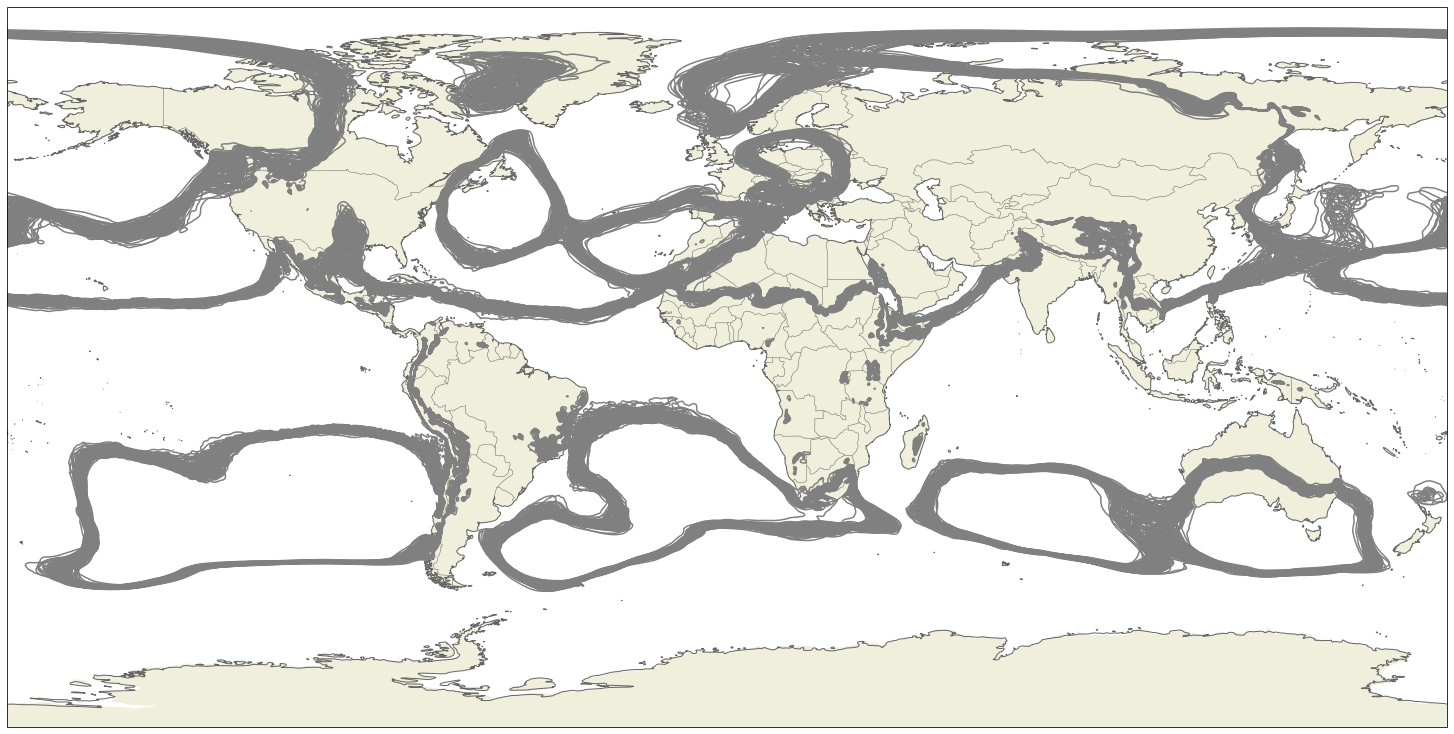

In [8]:
%%time
# ------- select data to be plotted
data_kept = data_raw.isel(step=i_step)

# ------- start figure
fig, ax = plt.subplots(1, 1, figsize=(20, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))

for i_num in data_kept.number.values:
    ax.contour(x, y, data_kept.sel(number=i_num),  
               transform=ccrs.PlateCarree(), levels=[used_level], colors=['grey'])

ax.coastlines(resolution='50m', linewidth=1, color='.4') # add coastline
ax.add_feature(cf.BORDERS, linewidth=.5, color='.4')
ax.add_feature(cf.LAND)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0)

fig.savefig(data_loc+f'PlateCarree_Spaghetti_{i_step+1}.png', dpi=600)
del(data_kept, fig, ax, i_num)

### Lasagna Plots
A modification of the spaghetti plots, where instead of plotting all members, areas with different confidence intervals are plooted. The confidence intervals relate to the number of ensemble members lying within the area. At the below plots there are two confidence intervals presented, one enclosing 90% of members (light blue), and one enclosing 50% of the members (darker blue). The minimum and maximum locations are also included in the plots as dotted lines.

Since the data are plotted based on probabilistic information, the shaded areas represent the spread but not the actual position of the ensemble members. This means that the shades cover also areas that no member was exaclty representing. This follows the same logic with the ensemble mean: The mean is the average of the members, but it is not a physical representation of the state of the system. 

Thanks to Petr Dolezal for suggesting technical ideas for speeding up the calculations.

In [9]:
def conf_level(data_input, conf_inter=0.9):
    
    """
    Masks data and only keeps the grid points that the percentage of ensemble members indicating the selected 
    contour level, lies within the defined confidence interval. Input data should be already pre-processed.
    
    !Note!: for very low confidence intervals (e.g. 0.0 -> show median) the method does not work!
    
    data_input : probabilities of data above given contour for the valid_time of interest [keep only (0, 1)]
    conf_inter : 2-tailed confidence interval of the "lasagna"; default: 0.9 (90%)
    """
    
    perc_lower_limit = (1-conf_inter)/2 # get the lower percentile of interest
    
    # keep gridpoints that the % of members indicating the countourlevel of interest lies within the confidence
    data_processed = data_input.where((data_input>=perc_lower_limit) & (data_input<=1-perc_lower_limit))
    data_processed = ~np.isnan(data_processed) # mask data and keep only the previously-kept gridpoints
    return data_processed*1

CPU times: user 11.3 s, sys: 260 ms, total: 11.5 s
Wall time: 11.6 s


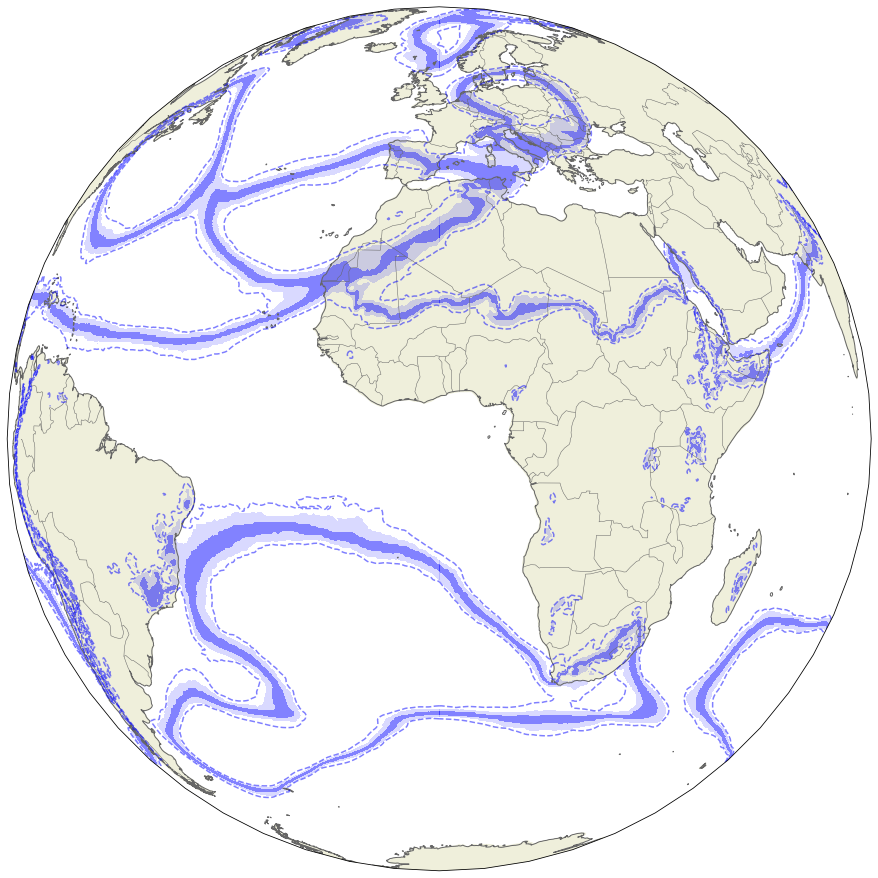

In [10]:
%%time
# ------- select data to be processed and plotted
data_kept = data_raw.isel(step=i_step)

# ------- get min, max for the respective contours
data_min = data_kept.min('number')
data_max = data_kept.max('number')

# ------- data preprocessing for generating the "lasagna"
data_probs = data_kept>used_level # boolean for each member & grid if it is above selected contour level
data_probs = data_probs.mean('number') # convert boolean to probabilistic

# Points that have prob==0 have always values below the selected level, so they can be masked.
# Similarly, points that have prob==1 have always values over the selected level, and can also be masked.
# All other values, relate to the percentage of ensemble members indicating the selected level.
data_probs = data_probs.where((data_probs!=0)&(data_probs!=1))

# ------- start figure
fig, ax = plt.subplots(1, 1, figsize=(20, 12), 
                       subplot_kw=dict(projection=ccrs.Orthographic()))

ax.contourf(x, y, conf_level(data_probs, .9), 
            transform=ccrs.PlateCarree(), levels=[0.9, 1.1], colors=['blue'], alpha=.15)

ax.contourf(x, y, conf_level(data_probs, .5),  
            transform=ccrs.PlateCarree(), levels=[0.9, 1.1], colors=['blue'], alpha=.40)

ax.contour(x, y, data_min, levels=[used_level], 
           transform=ccrs.PlateCarree(), colors=['blue'], linestyles=['--'], alpha=0.5)

ax.contour(x, y, data_max, levels=[used_level], 
           transform=ccrs.PlateCarree(), colors=['blue'], linestyles=['--'], alpha=0.5)

ax.coastlines(resolution='50m', linewidth=1, color='.4') # add coastline
ax.add_feature(cf.BORDERS, linewidth=.5, color='.4')
ax.add_feature(cf.LAND)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0)

fig.savefig(data_loc+f'Orthographic_Lasagna_{i_step+1}.png', dpi=600)
del(data_kept, data_min, data_max, data_probs, fig, ax)

CPU times: user 7.21 s, sys: 308 ms, total: 7.52 s
Wall time: 7.62 s


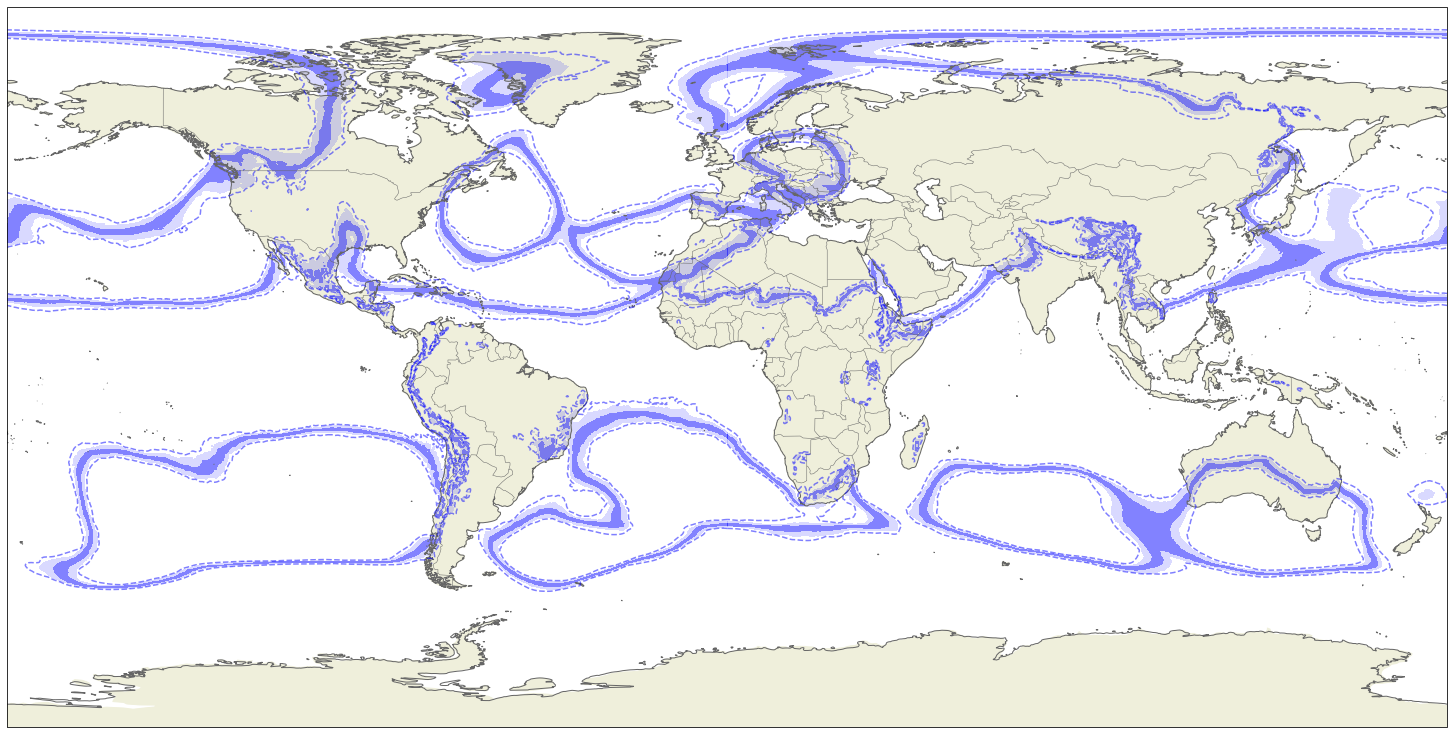

In [11]:
%%time
# ------- select data to be processed and plotted
data_kept = data_raw.isel(step=i_step)

# ------- get min, max for the respective contours
data_min = data_kept.min('number')
data_max = data_kept.max('number')

# ------- data preprocessing for generating the "lasagna"
data_probs = data_kept>used_level # boolean for each member & grid if it is above/below selected contour level
data_probs = data_probs.mean('number') # convert boolean to probabilistic

# Points that have prob==0 have always values below the selected level, so they can be masked.
# Similarly, points that have prob==1 have always values over the selected level, and can also be masked.
data_probs = data_probs.where((data_probs!=0)&(data_probs!=1))

# ------- start figure
fig, ax = plt.subplots(1, 1, figsize=(20, 12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.contourf(x, y, conf_level(data_probs, .9), 
            transform=ccrs.PlateCarree(), levels=[0.9, 1.1], colors=['blue'], alpha=.15)

ax.contourf(x, y, conf_level(data_probs, .5),  
            transform=ccrs.PlateCarree(), levels=[0.9, 1.1], colors=['blue'], alpha=.40)

ax.contour(x, y, data_min, levels=[used_level], 
           transform=ccrs.PlateCarree(), colors=['blue'], linestyles=['--'], alpha=0.5)

ax.contour(x, y, data_max, levels=[used_level], 
           transform=ccrs.PlateCarree(), colors=['blue'], linestyles=['--'], alpha=0.5)

ax.coastlines(resolution='50m', linewidth=1, color='.4') # add coastline
ax.add_feature(cf.BORDERS, linewidth=.5, color='.4')
ax.add_feature(cf.LAND)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0)

fig.savefig(data_loc+f'PlateCarree_Lasagna_{i_step+1}.png', dpi=600)
del(data_kept, data_min, data_max, data_probs, fig, ax)

Because of the clearer visualization, it is in fact possible to add 1 (or even 2) more additional contour levels on the plots.

CPU times: user 8.26 s, sys: 388 ms, total: 8.65 s
Wall time: 8.77 s


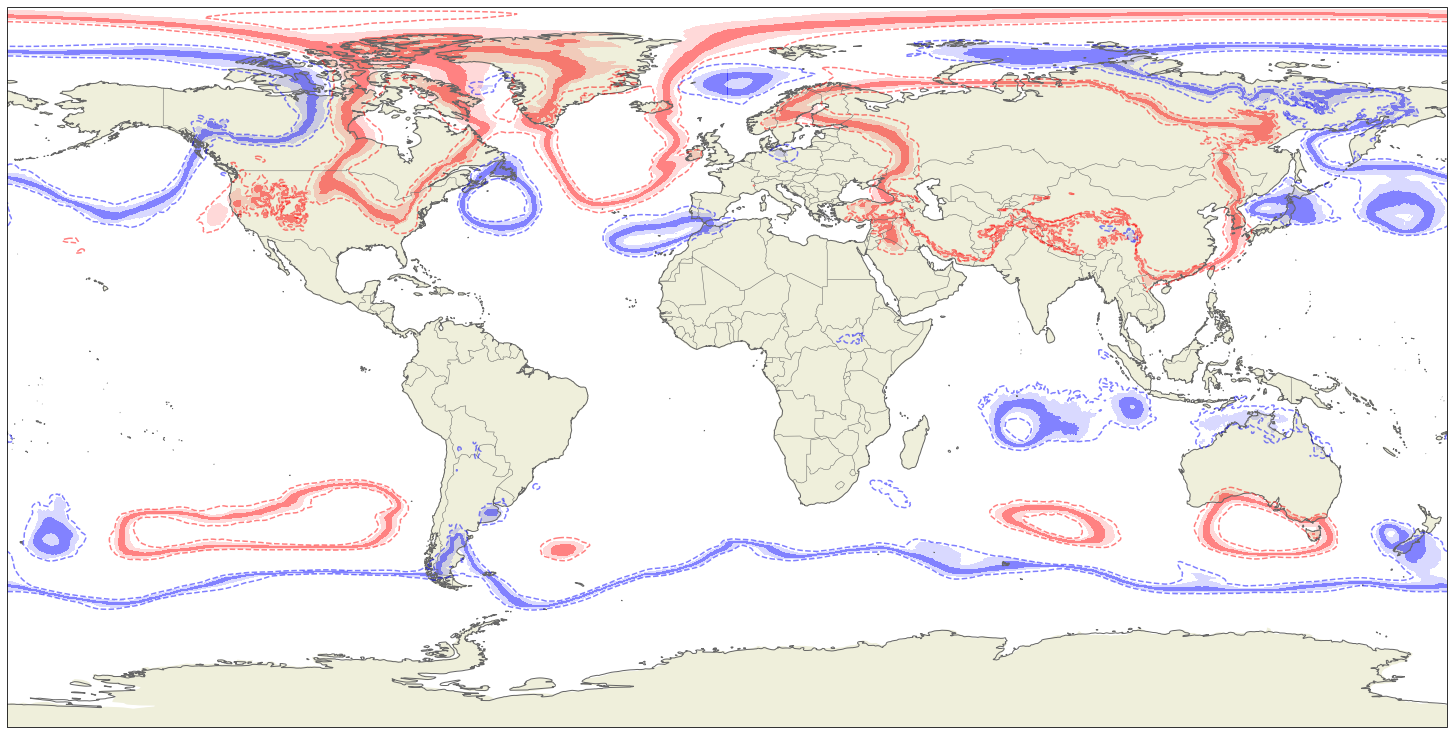

In [14]:
%%time
# ------- select data to be processed and plotted
data_kept = data_raw.isel(step=i_step)

# ------- get min, max for the respective contours
data_min = data_kept.min('number')
data_max = data_kept.max('number')

# ------- start figure
fig, ax = plt.subplots(1, 1, figsize=(20, 12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))

for i_level, i_color in zip([1005, 1025], ['blue', 'red']):
    # ------- data preprocessing for generating the "lasagna"
    data_probs = data_kept>i_level # boolean for each member & grid if above/below selected contour level
    data_probs = data_probs.mean('number') # convert boolean to probabilistic

    # Points that have prob==0 have always values below the selected level, so they can be masked.
    # Similarly, points that have prob==1 have always values over the selected level, and can also be masked.
    data_probs = data_probs.where((data_probs!=0)&(data_probs!=1))


    ax.contourf(x, y, conf_level(data_probs, .9), 
                transform=ccrs.PlateCarree(), levels=[0.9, 1.1], colors=[i_color], alpha=.15)

    ax.contourf(x, y, conf_level(data_probs, .5),  
                transform=ccrs.PlateCarree(), levels=[0.9, 1.1], colors=[i_color], alpha=.40)

    ax.contour(x, y, data_min, levels=[i_level], 
               transform=ccrs.PlateCarree(), colors=[i_color], linestyles=['--'], alpha=0.5)

    ax.contour(x, y, data_max, levels=[i_level], 
               transform=ccrs.PlateCarree(), colors=[i_color], linestyles=['--'], alpha=0.5)

ax.coastlines(resolution='50m', linewidth=1, color='.4') # add coastline
ax.add_feature(cf.BORDERS, linewidth=.5, color='.4')
ax.add_feature(cf.LAND)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0)

fig.savefig(data_loc+f'PlateCarree_Lasagna_{i_step+1}_Multilevels.png', dpi=600)
del(data_kept, data_min, data_max, data_probs, fig, ax)